In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import cm
from scipy.optimize import curve_fit
from scipy.special import wofz

In [2]:
data_folder = './data_Cavalie2023/HCN_data'

if os.path.exists(data_folder) and os.path.isdir(data_folder):
    files = os.listdir(data_folder)

    latitudes_file = os.path.join(data_folder,'latitudes_HCN.dat')

    data = np.genfromtxt(latitudes_file, skip_header=1, names=['pointing_number','latitude'])

    pointing_numbers = data['pointing_number']
    latitudes = data['latitude']
    
    # Create a dictionary from the pointing_number and latitude columns
    pointing_dict = {int(pointing['pointing_number']): pointing['latitude'] for pointing in data}

else:
    print(f"The folder '{data_folder}' does not exist")

In [6]:
f_rest_HCN54 = 354.505  # HCN5-4 线的静止频率，单位：GHz
c = 3e8  # 光速，单位：m/s
vol_equ = 12600 # km/s

def voigt(x, amplitude, center, sigma_L, sigma_G, baseline):
    z = ((x - center) + 1j * sigma_L) / (sigma_G * np.sqrt(2))
    V = amplitude * np.real(wofz(z)) / (sigma_G * np.sqrt(2 * np.pi))
    return baseline + V

In [236]:
class SpectrumData:
    def __init__(self,myid,*args):
        self.myid = myid
        # self.pointing_dict = pointing_dict

        # 定义spectrum文件的路径，基于myid
        spectrum_file = os.path.join(data_folder, f'spectrum_{self.myid}.dat')
        # 使用numpy.genfromtxt读取spectrum数据
        self.data = np.genfromtxt(spectrum_file, names=['Frequency_GHz', 'Flux_density_Jy_per_beam'])


    def integrate_spectrum(self): 
        # Calculate the integral of Flux_density_Jy_per_beam with respect to Frequency_GHz
        # integral = np.trapz(self.data['Flux_density_Jy_per_beam'])
        integral = np.trapz(self.data['Flux_density_Jy_per_beam'],x=self.data['Frequency_GHz'])
        return integral

    def get_max_flux_frequency(self):
        max_flux_index = np.argmax(self.data['Flux_density_Jy_per_beam'])
        max_flux_frequency = self.data['Frequency_GHz'][max_flux_index]
        return max_flux_frequency

    def plot_spectrum(self):
        if self.data is not None:
            # 在这里编写绘制spectrum图形的代码
            plt.figure()
            plt.plot(self.data['Frequency_GHz'], self.data['Flux_density_Jy_per_beam'])
            plt.title(f'Spectrum for myid {self.myid}')
            plt.xlabel('Frequency (GHz)')
            plt.ylabel('Flux Density (Jy/beam)')
            plt.show()
        else:
            print(f"Spectrum data for myid {self.myid} not found.")

    def fit_spectrum_center(self,plot=False,shape='ellips'):
        # 初始化拟合参数的初值
        max_flux_fre = self.get_max_flux_frequency()
        """
        Old Version:0918

        if self.myid == 136:
            initial_guess = [1, 354.5051, 0.01, 0.01, 0.0] # Used the max flux frequency as the initial wavlen centre
        else:
            initial_guess = [1, max_flux_fre, 0.01, 0.01, 0.0] # Used the max flux frequency as the initial wavlen centre
        
        # 使用curve_fit进行Voigt拟合
        params, covariance = curve_fit(voigt, self.data['Frequency_GHz'], self.data['Flux_density_Jy_per_beam'], p0=initial_guess,method='lm')

        """
        initial_guess = [0, max_flux_fre, 0.01, 0.001, 0.0] # Used the max flux frequency as the initial wavlen centre

        xdata = self.data['Frequency_GHz']
        ydata = self.data['Flux_density_Jy_per_beam']
        mask = (xdata > max_flux_fre - 0.01) & (xdata < max_flux_fre + 0.01) # Mask 掉峰值频率附近0.02GHz带宽的数据
        xfit = xdata[mask]
        yfit = ydata[mask]

        params, covariance = curve_fit(voigt, xfit, yfit, 
                                    bounds=[(0,max_flux_fre-0.01,0,0,-np.inf),(4,max_flux_fre+0.01,0.1,0.01,np.inf)],
                                    p0=initial_guess,method='trf')
        
        # 拟合参数
        amplitude, center, sigma_L, sigma_G, baseline = params

        if plot :
        # 绘制原始光谱和Voigt拟合曲线
            plt.figure(figsize=(8, 6))
            plt.plot(self.data['Frequency_GHz'], self.data['Flux_density_Jy_per_beam'], label='HCN 5-4 Spectrum', color='b')
            plt.plot(self.data['Frequency_GHz'], voigt(self.data['Frequency_GHz'], *params), label='Voigt Fit', color='r')
        # 计算自转引起频移
            plt.axvline(x=f_rest_HCN54, color='g', linestyle='--', label='Rest Frequency')
            # f_spin_HCN54 = self.cal_rotation_shifted_position()
            f_spin_HCN54 = self.cal_position(model=shape)
            plt.axvline(x=f_spin_HCN54, color='y', linestyle='--', label='Spin-included Frequency')   
        # 计算定量风引起多普勒频移
            wind_speed = 100
            delta_f = f_rest_HCN54 * (wind_speed / 3e8)
            ymin, ymax = plt.ylim()
            # 绘制带状区域
            plt.fill_betweenx(y=[ymin, ymax], x1=f_spin_HCN54 - 10*delta_f, x2=f_spin_HCN54 + 10*delta_f, alpha=0.2, label=f'Wind Speed ~ {10*wind_speed} m/s')
            plt.fill_betweenx(y=[ymin, ymax], x1=f_spin_HCN54 - 5*delta_f, x2=f_spin_HCN54 + 5*delta_f, alpha=0.2, label=f'Wind Speed ~ {5*wind_speed} m/s')
            plt.fill_betweenx(y=[ymin, ymax], x1=f_spin_HCN54 - 2*delta_f, x2=f_spin_HCN54 + 2*delta_f, alpha=0.2, label=f'Wind Speed ~ {2*wind_speed} m/s')
            plt.xlim(center-0.02,center+0.02)
        # 图题图例    
            plt.xlabel('Frequency (GHz)')
            plt.ylabel('Flux Density (Jy/beam)')
            plt.title(f'HCN 5-4 Line Spectrum and Voigt Fit. id:{self.myid}')
            plt.legend()
            print(f'center = {center} GHz')
            if self.is_east():
                print('Eastern Limb, Lat = ',pointing_dict[self.myid])
                print('mea_windspeed=',(f_spin_HCN54-center)/f_rest_HCN54*c,'m/s')
            else:
                print('Western Limb, Lat = ',pointing_dict[self.myid])
                print('mea_windspeed=',(center-f_spin_HCN54)/f_rest_HCN54*c,'m/s')
            return 
        return center
    
    def is_east(self):
        i = self.myid
        if i < 139 or i > 417:
            return True
        else:
            return False
    
    def tran_lat(self):
        i = self.myid
        if i<139 or i > 417: #East
            angle = np.deg2rad(latitudes[i])
        else :  #West
            angle = np.deg2rad(180-latitudes[i])
        return angle        
        
    def cal_solidrot_vol(self,model):
        angle = self.tran_lat()
        if model == 'sphere':
            vol_phi = vol_equ * np.cos(angle)
        elif model == 'ellips':
            epl = 0.065
            vol_phi = vol_equ * (1 + np.tan(angle)**2 / (1-epl)**2)**(-0.5)
            vol_phi *= np.sign(np.cos(angle))
        else :
            print(f"The '{model}' model does not exist")
        vol_phi = vol_phi*np.cos(np.deg2rad(3)) #修正倾斜
        return vol_phi
    
    def cal_position(self,model='ellips'):
        if model == 'sphere':
            rotvol = self.cal_solidrot_vol('sphere')
        elif model == 'ellips':
            rotvol = self.cal_solidrot_vol('ellips')
        else :
            print(f"The '{model}' model does not exist")
        f_rest_HCN54 = 354.505  # HCN5-4 线的静止频率，单位：GHz
        c = 3e8  # 光速，单位：m/s
        delta_f = f_rest_HCN54 * (-rotvol/c) 
        position = f_rest_HCN54 + delta_f
        return position       
    
    def cal_rotation_shifted_position(self):
        '''
        旧的频移计算函数
        '''
        i = self.myid
        if i<139 or i > 417: #East
            angle = latitudes[i]/180*np.pi
        else :  #West
            angle = (180-latitudes[i])/180*np.pi

        f_rest_HCN54 = 354.505  # HCN5-4 线的静止频率，单位：GHz
        c = 3e8  # 光速，单位：m/s
        vol_equ = 12600
        vol_obital =  vol_equ * np.cos(angle)  
        
        # vol_obital = vol_obital * p(angle) # 考虑木星扁率6.5%
        epl = 0.065
        vol_phi = vol_equ * (1 + np.tan(angle)**2 / (1-epl)**2)**(-0.5)
        vol_phi *= np.sign(np.cos(angle)) #判断方向

        # 计算多普勒频移
        delta_f = f_rest_HCN54 * (-vol_phi / c) #速度以木星自转方向为正，北逆，负号表示东西半球的红移和蓝移
        position = f_rest_HCN54 + delta_f
        return position
    


In [237]:

spectrum = SpectrumData(518)
spectrum.cal_position(model='sphere')-spectrum.cal_rotation_shifted_position()

-0.00015358461030245962

center = 354.5145878106623 GHz
Western Limb, Lat =  -50.2355079651
mea_windspeed= 387.0687827748503 m/s


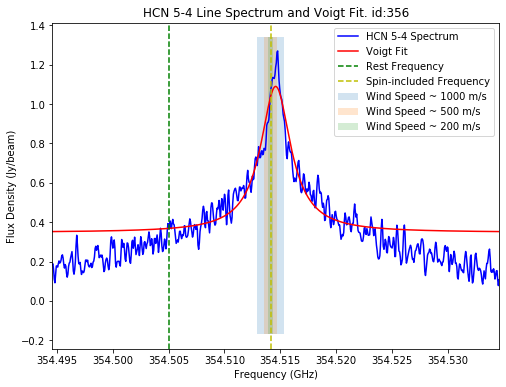

In [248]:
spectrum = SpectrumData(356)
spectrum.fit_spectrum_center(plot=True)

In [28]:
myids = np.array([int(x) for x in pointing_numbers])
# change CO observation latitude(-90,90) to angle(0,2pi)
angles = np.zeros(latitudes.shape)

for i in myids:
    if i<139 or i > 417: #East
        angles[i]=latitudes[i]/180*np.pi
        # print(i,angles[i])
    else :  #West
        angles[i]= (180-latitudes[i])/180*np.pi
        # print(i,angles[i])

center = 354.490617963647 GHz
[4.89796658e-03 3.54490618e+02 2.43651466e-03 9.97286747e-26
 3.28532602e-01]


(354.46, 354.56)

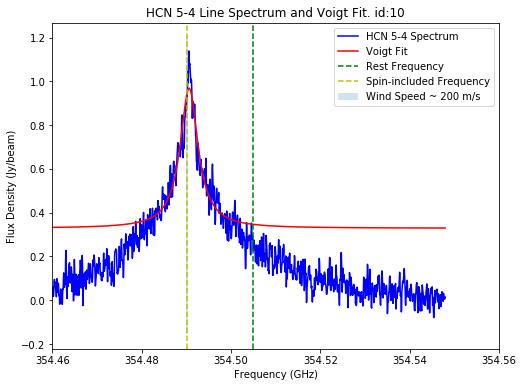

In [81]:


def cal_rotation_shifted(myid):
    vol_equ = 12600
    vol_obital =  vol_equ * -np.cos(angles[myid])  #负号表示东西半球的红移和蓝移
    
    #Doppler shift
    # v_observed = vol_obital * p(angles[myid]) # 观测者看到的速度，单位：m/s 
    v_observed = vol_obital

    # 计算多普勒频移
    delta_f = f_rest_HCN54 * (v_observed / c)

    return delta_f

selected_id = 10
spectrum_1 = SpectrumData(selected_id)
data_1 = spectrum_1.data
# spectrum_1.plot_spectrum()
max_flux_fre_1 = spectrum_1.get_max_flux_frequency()

# 定义Voigt拟合函数
def voigt(x, amplitude, center, sigma_L, sigma_G, baseline):
    z = ((x - center) + 1j * sigma_L) / (sigma_G * np.sqrt(2))
    V = amplitude * np.real(wofz(z)) / (sigma_G * np.sqrt(2 * np.pi))
    return baseline + V

# 初始化拟合参数的初值
# initial_guess = [1, 354.5051, 0.01, 0.01, 0.0]
initial_guess = [0, max_flux_fre_1, 0.01, 0.001, 0.0] # Used the max flux frequency as the initial wavlen centre

xdata = data_1['Frequency_GHz']
ydata = data_1['Flux_density_Jy_per_beam']
mask = (xdata > max_flux_fre_1 - 0.01) & (xdata < max_flux_fre_1 + 0.01)
xfit = xdata[mask]
yfit = ydata[mask]

params, covariance = curve_fit(voigt, xfit, yfit, 
                               bounds=[(0,max_flux_fre_1-0.01,0,0,-np.inf),(4,max_flux_fre_1+0.01,0.1,0.01,np.inf)],
                               p0=initial_guess,method='trf')

# 使用curve_fit进行Voigt拟合
# params, covariance = curve_fit(voigt, data_1['Frequency_GHz'], data_1['Flux_density_Jy_per_beam'], 
#                             #    bounds=[(0,max_flux_fre_1-0.01,0,1.e-3,-np.inf),(4,max_flux_fre_1+0.01,0.1,0.01,np.inf)],
#                                p0=initial_guess,method='lm')

# 拟合参数
amplitude, center, sigma_L, sigma_G, baseline = params

# 绘制原始光谱和Voigt拟合曲线
plt.figure(figsize=(8, 6))
plt.plot(data_1['Frequency_GHz'], data_1['Flux_density_Jy_per_beam'], label='HCN 5-4 Spectrum', color='b')
plt.plot(data_1['Frequency_GHz'], voigt(data_1['Frequency_GHz'], *params), label='Voigt Fit', color='r')

plt.axvline(x=f_rest_HCN54, color='g', linestyle='--', label='Rest Frequency')
f_spin_HCN54 = f_rest_HCN54 + cal_rotation_shifted(selected_id)
plt.axvline(x=f_spin_HCN54, color='y', linestyle='--', label='Spin-included Frequency')

# 计算多普勒频移
wind_speed = 200
delta_f = f_rest_HCN54 * (wind_speed / 3e8)

ymin, ymax = plt.ylim()
# 绘制带状区域
plt.fill_betweenx(y=[ymin, ymax], x1=f_spin_HCN54 - delta_f, x2=f_spin_HCN54 + delta_f, alpha=0.2, label=f'Wind Speed ~ {wind_speed} m/s')


plt.xlabel('Frequency (GHz)')
plt.ylabel('Flux Density (Jy/beam)')
# plt.title('CO 3-2 Line Spectrum and Voigt Fit at 0.32N,Eastern-limb')
plt.title(f'HCN 5-4 Line Spectrum and Voigt Fit. id:{selected_id}')
plt.legend()
print(f'center = {center} GHz')
print(params)
plt.xlim(354.46,354.56)


In [241]:
# 储存拟合线心的位置
myids = np.array([int(x) for x in pointing_numbers])
spectrum_instances = [SpectrumData(myid) for myid in myids]

linecen_list = []
for i,instance in enumerate(spectrum_instances):
    linecen_list.append(instance.fit_spectrum_center())

In [245]:
# 计算理论频移
solidshift_list = []
fix_rot_shifts = [] #蓝移量
for i,instance in enumerate(spectrum_instances):
    solidshift_list.append(instance.cal_position())
    fix_rot_shifts.append(linecen_list[i]-solidshift_list[i])


In [229]:
# Plot Shiftes 
# 创建不同myid的SpectrumData实例
myids = np.array([int(x) for x in pointing_numbers])
# myids = np.arange(136,137)
spectrum_instances = [SpectrumData(myid) for myid in myids]

plt.figure(figsize=(12,6))
color_map = cm.plasma_r
shifts = []
fix_rot_shifts = [] #蓝移量
# 读取并绘制不同myid的spectrum数据
for i,instance in enumerate(spectrum_instances):
    # color = color_map((i+1)/ len(spectrum_instances))
    shifts.append(instance.fit_spectrum_center() - f_rest_HCN54)
    # fix_rot_shifts.append(instance.fit_spectrum_center()-instance.cal_rotation_shifted_position())
    fix_rot_shifts.append(instance.fit_spectrum_center()-instance.cal_position(model='sphere'))
    # plt.plot(instance.data['Frequency_GHz'], instance.data['Flux_density_Jy_per_beam'],color = color,label=legend_pair)




<Figure size 864x432 with 0 Axes>

Text(0.5, 1.0, 'Winds from HCN, in ellipse, i')

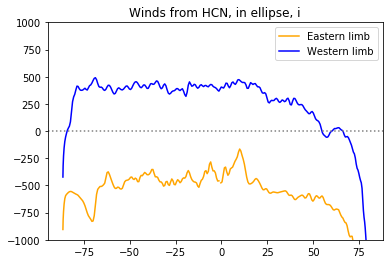

In [247]:
wind_speeds = np.array([-shift * c / f_rest_HCN54 for shift in fix_rot_shifts])
plt.plot(latitudes[0:139],wind_speeds[0:139],label='Eastern limb',color='orange')
plt.plot(latitudes[418:-1],wind_speeds[418:-1],color='orange')
plt.plot(latitudes[139:418],-wind_speeds[139:418],label='Western limb',color = 'blue')
plt.axhline(0,linestyle=':',color='grey')
plt.ylim(-1000,1000)
plt.legend()
plt.title('Winds from HCN, in ellipse, i')

Text(0.5, 1.0, 'Winds from HCN')

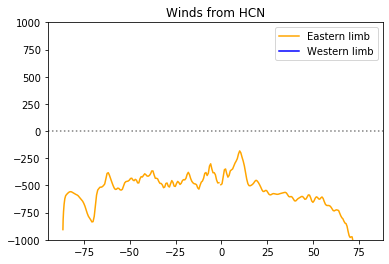

In [25]:
wind_speeds = [-shift * c / f_rest_HCN54 for shift in fix_rot_shifts]
plt.plot(latitudes[0:139],wind_speeds[0:139],label='Eastern limb',color='orange')
plt.plot(latitudes[418:-1],wind_speeds[418:-1],color='orange')
plt.plot(latitudes[139:418],wind_speeds[139:418],label='Western limb',color = 'blue')
plt.axhline(0,linestyle=':',color='grey')
plt.ylim(-1000,1000)
plt.legend()
plt.title('Winds from HCN')

Text(0.5, 1.0, 'Winds from HCN')

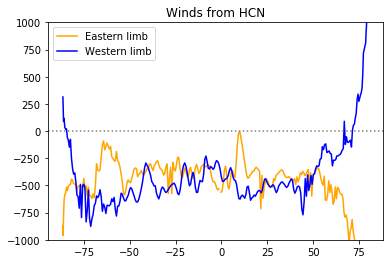

In [ ]:
wind_speeds = [-shift * c / f_rest_HCN54 for shift in fix_rot_shifts]
plt.plot(latitudes[0:139],wind_speeds[0:139],label='Eastern limb',color='orange')
plt.plot(latitudes[418:-1],wind_speeds[418:-1],color='orange')
plt.plot(latitudes[139:418],wind_speeds[139:418],label='Western limb',color = 'blue')
plt.axhline(0,linestyle=':',color='grey')
plt.ylim(-1000,1000)
plt.legend()
plt.title('Winds from HCN')

Text(0.5, 1.0, 'Winds from HCN')

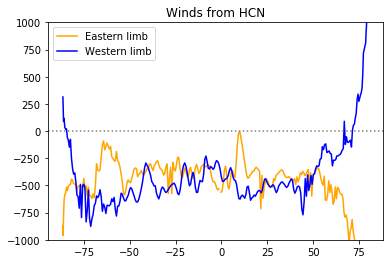

In [ ]:
wind_speeds = [-shift * c / f_rest_HCN54 for shift in fix_rot_shifts]
plt.plot(latitudes[0:139],wind_speeds[0:139],label='Eastern limb',color='orange')
plt.plot(latitudes[418:-1],wind_speeds[418:-1],color='orange')
plt.plot(latitudes[139:418],wind_speeds[139:418],label='Western limb',color = 'blue')
plt.axhline(0,linestyle=':',color='grey')
plt.ylim(-1000,1000)
plt.legend()
plt.title('Winds from HCN')

Text(0.5, 1.0, 'Winds from HCN')

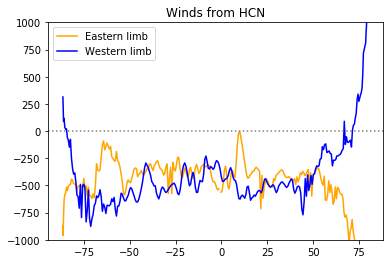

In [10]:
wind_speeds = [-shift * c / f_rest_HCN54 for shift in fix_rot_shifts]
plt.plot(latitudes[0:139],wind_speeds[0:139],label='Eastern limb',color='orange')
plt.plot(latitudes[418:-1],wind_speeds[418:-1],color='orange')
plt.plot(latitudes[139:418],wind_speeds[139:418],label='Western limb',color = 'blue')
plt.axhline(0,linestyle=':',color='grey')
plt.ylim(-1000,1000)
plt.legend()
plt.title('Winds from HCN')

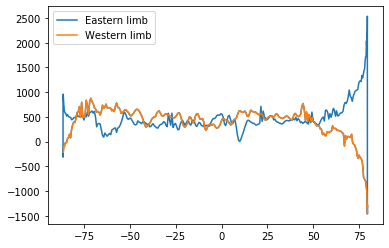

In [11]:
wind_speeds = [shift * c / f_rest_HCN54 for shift in fix_rot_shifts]
plt.plot(latitudes,wind_speeds,label='Eastern limb')
plt.plot(latitudes[139:417],wind_speeds[139:417],label='Western limb')
# plt.ylim(-1000,1000)
plt.legend()